# MVP in Altair

So, in the explore.ipynb notebook, I identified some initial observations for a 'minimum viable project,' but the 
graphs are very basic, ugly pandas graphs. These are great for an analyst to get a quick look at data, but
for business slides you'd want something more consistent, nice axis labels, and so on. 

I made these with Altair.

In [1]:
import pandas as pd
import numpy as np
import altair as alt

from pathlib import Path

In [2]:
%load_ext watermark
%watermark -iv

altair 3.1.0
pandas 0.24.2
numpy  1.16.4



In [3]:
# Data load
data = Path('../data/churn_cleaned.pkl')
assert(data.exists())
df = pd.read_pickle(data)
df.shape

(7043, 21)

In [4]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

# Overview - who churned?

In [5]:
def total_percent(df, group, column):
    totals = df.groupby(group)[column].sum()
    totals.name = 'total'
    df = df.join(totals, how='left', on=group)
    df['percent'] = round(df[column].astype(float) * 100 / df.total.astype(float))
    df['percent'] = df['percent'].astype(int).astype(str) + '%'
    return df

In [6]:
df['cust_type'] = ''
df.loc[(df.PhoneService == 'Yes') & (df.InternetService == 'No'), 'cust_type'] = 'Phone'
df.loc[(df.PhoneService == 'No') & (df.InternetService != 'No'), 'cust_type'] = 'Internet'
df.loc[df.cust_type == '', 'cust_type'] = 'Both'
chart_data = df.groupby(['cust_type','Churn'])['customerID'].count().reset_index()
chart_data = total_percent(chart_data, 'cust_type', 'customerID')

chart_data

,cust_type,Churn,customerID,total,percent
0,Both,No,3249,4835,67%
1,Both,Yes,1586,4835,33%
2,Internet,No,512,682,75%
3,Internet,Yes,170,682,25%
4,Phone,No,1413,1526,93%
5,Phone,Yes,113,1526,7%


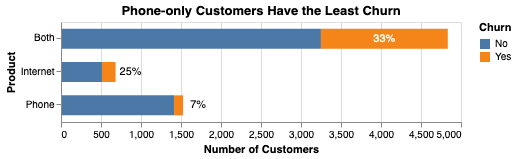

In [7]:
bars = alt.Chart(chart_data,
                title='Phone-only Customers Have the Least Churn',
                height=100
         ).mark_bar(
                size=20
         ).encode(
                alt.X('sum(customerID)', title='Number of Customers'),
                alt.Y('cust_type', title='Product'),
                color='Churn',
                order=alt.Order(
                    'Churn',
                    sort='ascending'
                )
         )

text_side = alt.Chart(
    chart_data.query('Churn == "Yes" and cust_type != "Both"')).mark_text(dx=15).encode(
    x=alt.X('total'),
    y=alt.Y('cust_type'),
    text=alt.Text('percent')
)

text_center = alt.Chart(
    chart_data.query('Churn == "Yes" and cust_type == "Both"')).mark_text(color='white').encode(
    x='x:Q',
    y=alt.Y('cust_type'),
    text=alt.Text('percent')
).transform_calculate(
    x='datum.total - datum.customerID/2'
)

(bars + text_side + text_center)

# Internet Churn by Product

In [8]:
chart_data = df.groupby(["InternetService","Churn"])['customerID'].count().reset_index()
chart_data = chart_data.query('InternetService != "No"')
chart_data = total_percent(chart_data, 'InternetService', 'customerID')

chart_data['pct_pos'] = chart_data.total - chart_data.customerID/2
chart_data

,InternetService,Churn,customerID,total,percent,pct_pos
0,DSL,No,1962,2421,81%,1440.0
1,DSL,Yes,459,2421,19%,2191.5
2,Fiber optic,No,1799,3096,58%,2196.5
3,Fiber optic,Yes,1297,3096,42%,2447.5


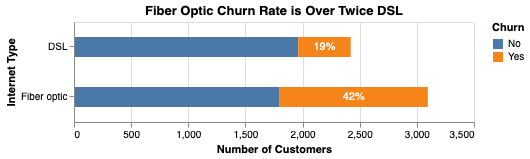

In [9]:
bars = alt.Chart(chart_data,
         title='Fiber Optic Churn Rate is Over Twice DSL',
         height=100
         ).mark_bar(
            size=20
         ).encode(
            alt.X('sum(customerID)', title='Number of Customers'),
            alt.Y('InternetService', title='Internet Type'),
            color='Churn',
            order=alt.Order(
                'Churn',
                sort='ascending'
            )
         )

text = alt.Chart(chart_data.query('Churn == "Yes"')).mark_text(color='white').encode(
    x="x:Q",
    y=alt.Y('InternetService'),
    text=alt.Text('percent')
).transform_calculate(
    x='datum.total - datum.customerID/2'
)

(bars + text)

# Churn by Monthly Charges

In [10]:
df['MonthlyChargeBin'] = pd.cut(df.MonthlyCharges, bins=5).astype(str)
chart_data = df.groupby(['MonthlyChargeBin','Churn'])['customerID'].count().reset_index()
chart_data = total_percent(chart_data, 'MonthlyChargeBin', 'customerID')
chart_data

,MonthlyChargeBin,Churn,customerID,total,percent
0,"(18.15, 38.35]",No,1592,1797,89%
1,"(18.15, 38.35]",Yes,205,1797,11%
2,"(38.35, 58.45]",No,734,1005,73%
3,"(38.35, 58.45]",Yes,271,1005,27%
4,"(58.45, 78.55]",No,964,1367,71%
5,"(58.45, 78.55]",Yes,403,1367,29%
6,"(78.55, 98.65]",No,1151,1826,63%
7,"(78.55, 98.65]",Yes,675,1826,37%
8,"(98.65, 118.75]",No,733,1048,70%
9,"(98.65, 118.75]",Yes,315,1048,30%


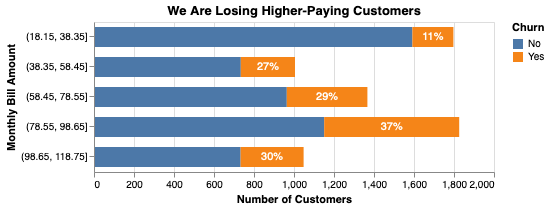

In [11]:
bars = alt.Chart(chart_data,
         title='We Are Losing Higher-Paying Customers',
         height=150
         ).mark_bar(
            size=20
         ).encode(
            alt.X('sum(customerID)', title='Number of Customers'),
            alt.Y('MonthlyChargeBin',title='Monthly Bill Amount'),
            color='Churn',
            order=alt.Order(
                'Churn',
                sort='ascending'
            )
         )

text = alt.Chart(chart_data.query('Churn == "Yes"')).mark_text(color='white').encode(
    x="x:Q",
    y=alt.Y('MonthlyChargeBin'),
    text=alt.Text('percent')
).transform_calculate(
    x='datum.total - datum.customerID/2'
)

(bars + text)


# New Customer Churn

In [12]:
df['NewCustomer'] = df.tenure <= 11

In [13]:
chart_data = df.groupby(['NewCustomer','Churn'])['customerID'].count().reset_index()
chart_data.NewCustomer = chart_data.NewCustomer.map({True:'Less than One Year',False:'One Year+'})
chart_data = total_percent(chart_data, 'NewCustomer', 'customerID')

chart_data

,NewCustomer,Churn,customerID,total,percent
0,One Year+,No,4104,4974,83%
1,One Year+,Yes,870,4974,17%
2,Less than One Year,No,1070,2069,52%
3,Less than One Year,Yes,999,2069,48%


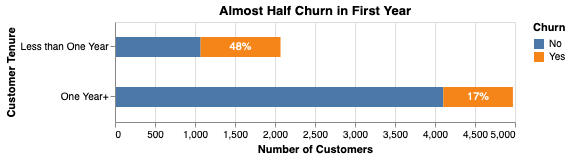

In [14]:
bars = alt.Chart(chart_data,
             title='Almost Half Churn in First Year',
             height=100
         ).mark_bar(
            size=20
         ).encode(
            alt.X('sum(customerID)', title='Number of Customers'),
            alt.Y('NewCustomer', title='Customer Tenure'),
            color='Churn',
            order=alt.Order(
                'Churn',
                sort='ascending'
            )
         )

text = alt.Chart(chart_data.query('Churn == "Yes"')).mark_text(color='white').encode(
    x="x:Q",
    y=alt.Y('NewCustomer'),
    text=alt.Text('percent')
).transform_calculate(
    x='datum.total - datum.customerID/2'
)

(bars + text)

In [15]:
chart_data = df.query('tenure <= 12 and tenure > 0').groupby(['tenure','Churn'])['customerID'].count().reset_index()
chart_data = total_percent(chart_data, 'tenure', 'customerID')
chart_data

,tenure,Churn,customerID,total,percent
0,1,No,233,613,38%
1,1,Yes,380,613,62%
2,2,No,115,238,48%
3,2,Yes,123,238,52%
4,3,No,106,200,53%
5,3,Yes,94,200,47%
6,4,No,93,176,53%
7,4,Yes,83,176,47%
8,5,No,69,133,52%
9,5,Yes,64,133,48%


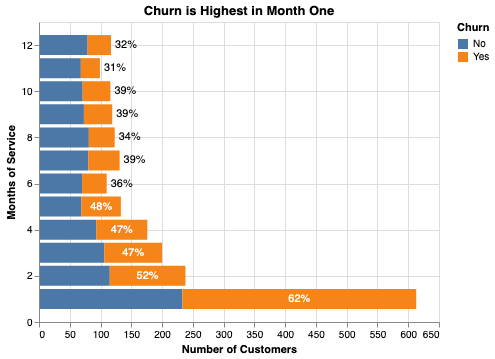

In [16]:
bars = alt.Chart(chart_data,
         title='Churn is Highest in Month One'
         ).mark_bar(
                size=20,
                dy=5
         ).encode(
            alt.X('sum(customerID)', title='Number of Customers'),
            alt.Y('tenure', title='Months of Service', sort='ascending'),
            color='Churn',
            order=alt.Order(
                'Churn',
                sort='ascending'
            )
         )

yes = chart_data.query('Churn == "Yes"')
text = alt.Chart(yes.query('tenure <= 5')).mark_text(
    color='white').encode(
    x="x:Q",
    y=alt.Y('tenure'),
    text=alt.Text('percent')
).transform_calculate(
    x='datum.total - datum.customerID/2'
)

text_side = alt.Chart(yes.query('tenure >5')).mark_text(
    dx=15
).encode(
    x=alt.X('total'),
    y=alt.Y('tenure'),
    text=alt.Text('percent')
)

bars + text + text_side

# Payment Method

In [17]:
chart_data = df.groupby(['PaymentMethod', 'Churn'])['customerID'].count().reset_index()
chart_data  = total_percent(chart_data, 'PaymentMethod', 'customerID')
chart_data 

,PaymentMethod,Churn,customerID,total,percent
0,Bank transfer (automatic),No,1286,1544,83%
1,Bank transfer (automatic),Yes,258,1544,17%
2,Credit card (automatic),No,1290,1522,85%
3,Credit card (automatic),Yes,232,1522,15%
4,Electronic check,No,1294,2365,55%
5,Electronic check,Yes,1071,2365,45%
6,Mailed check,No,1304,1612,81%
7,Mailed check,Yes,308,1612,19%


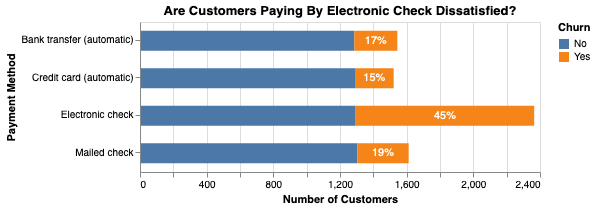

In [18]:
bars = alt.Chart(chart_data,
             title='Are Customers Paying By Electronic Check Dissatisfied?',
             height=150
         ).mark_bar(
            size=20
         ).encode(
            alt.X('sum(customerID)', title='Number of Customers'),
            alt.Y('PaymentMethod:N', title='Payment Method'),
            color='Churn',
            order=alt.Order(
                'Churn',
                sort='ascending'
            )
         )

text = alt.Chart(chart_data
                ).mark_text(
                    color='white'
                ).encode(
                    x="x:Q",
                    y=alt.Y('PaymentMethod:N'),
                    text=alt.Text('percent')
                ).transform_calculate(
                    x='datum.total - datum.customerID/2'
                ).transform_filter(
                    "datum.Churn == 'Yes'" 
                )

bars + text